In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../")
import macrophages_analysis

In [2]:
raw_data_path = '../../20x_datasets/Raw_data/'
preprocessed_data_path = '../../20x_datasets/Preprocessed_data/'

# Basic preprocessing

## Prepocessing of 20x CD206 P4G4 nucleus data

In [3]:
# read CD206 P4G4 nucleus data
nuclei_m1 = pd.read_csv(raw_data_path + "20x_nuclei_P4G4_CD206_M1_NucleiObj.csv")
nuclei_m2_nt = pd.read_csv(raw_data_path + "20x_nuclei_P4G4_CD206_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1['CellType'] = 'M1'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([1,2,3,4]), 'CellType'] = 'M2'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([5,6,7,8,9]), 'CellType'] = 'NT'
nucleus_dataset_p4g4 = nuclei_m1.merge(nuclei_m2_nt, how='outer')

## Prepocessing of 20x CD206 Smooth nucleus data

In [4]:
# read CD206 P4G4 nucleus data
nuclei_m1 = pd.read_csv(raw_data_path + "20x_nuclei_Smooth_CD206_M1_NucleiObj.csv")
nuclei_m2_nt = pd.read_csv(raw_data_path + "20x_nuclei_Smooth_CD206_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1['CellType'] = 'M1'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([1,2,3]), 'CellType'] = 'M2'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([4,5,6]), 'CellType'] = 'NT'
nucleus_dataset_smooth = nuclei_m1.merge(nuclei_m2_nt, how='outer')

## Prepocessing of 20x CD86 TCPS nucleus data

In [5]:
# read CD206 TCPS nucleus data
nuclei_m1 = pd.read_csv(raw_data_path + "20x_nuclei_TCPS_CD206_M1_NucleiObj.csv")
nuclei_m2_nt = pd.read_csv(raw_data_path + "20x_nuclei_TCPS_CD206_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1['CellType'] = 'M1'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([1,2,3,4,5]), 'CellType'] = 'M2'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([6,7,8,9]), 'CellType'] = 'NT'
nucleus_dataset_tcps = nuclei_m1.merge(nuclei_m2_nt, how='outer')

In [6]:
num_datasets = 3
nucleus_datasets = [nucleus_dataset_p4g4,
                nucleus_dataset_tcps,
                nucleus_dataset_smooth
                ]

clean_datasets = []
for i in range(num_datasets):
    dataset = nucleus_datasets[i].copy()
    dataset.drop(['ImageNumber', 'ObjectNumber', 'Number_Object_Number'], axis=1, inplace=True)
    dataset = dataset.loc[:, (nucleus_datasets[i] != nucleus_datasets[i].iloc[0]).any()]
    dataset = macrophages_analysis.remove_outliers(dataset, 'Intensity_IntegratedIntensity_Nuclei', method='percentile')
    dataset = macrophages_analysis.remove_outliers(dataset, 'Texture_Contrast_Nuclei_3_00_256', method='percentile')
    clean_datasets.append(dataset)

<Axes: title={'center': 'Texture_Contrast_Nuclei_3_00_256'}, xlabel='CellType'>

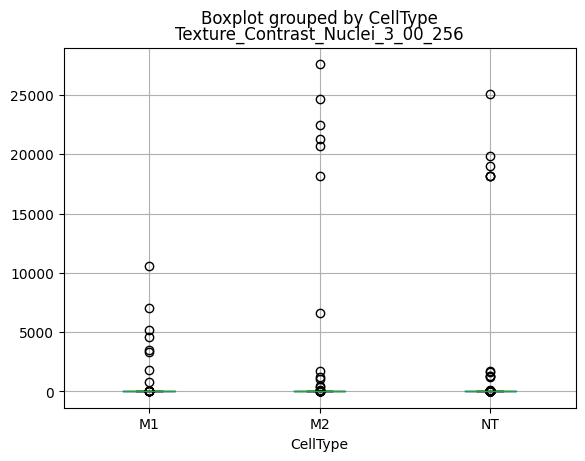

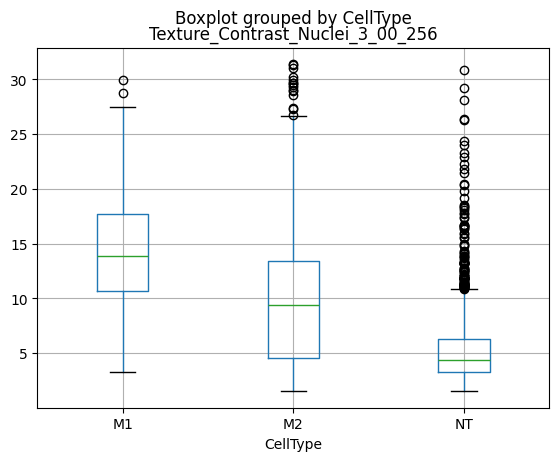

In [7]:
all_surfaces_before = pd.concat([nucleus_datasets[0], nucleus_datasets[1], nucleus_datasets[2]])
all_surfaces_after = pd.concat([clean_datasets[0], clean_datasets[1], clean_datasets[2]])

all_surfaces_before.boxplot('Texture_Contrast_Nuclei_3_00_256', by='CellType')
all_surfaces_after.boxplot('Texture_Contrast_Nuclei_3_00_256', by='CellType')

<Axes: title={'center': 'Intensity_IntegratedIntensity_Nuclei'}, xlabel='CellType'>

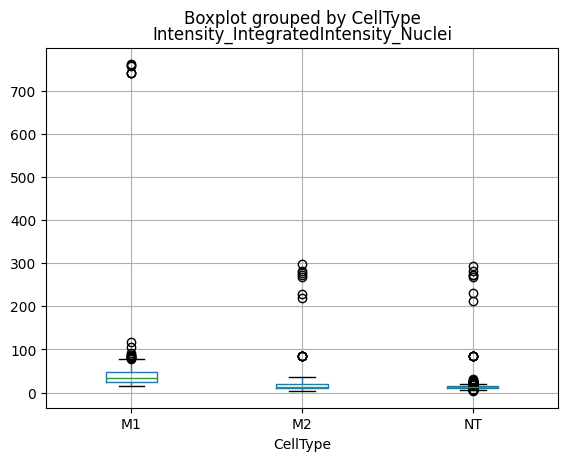

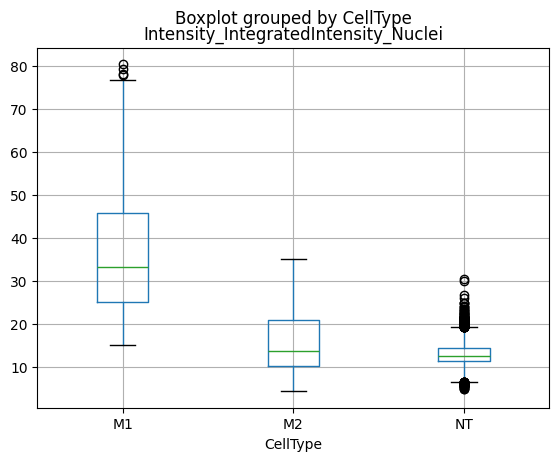

In [8]:
all_surfaces_before = pd.concat([nucleus_datasets[0], nucleus_datasets[1], nucleus_datasets[2]])
all_surfaces_after = pd.concat([clean_datasets[0], clean_datasets[1], clean_datasets[2]])

all_surfaces_before.boxplot('Intensity_IntegratedIntensity_Nuclei', by='CellType')
all_surfaces_after.boxplot('Intensity_IntegratedIntensity_Nuclei', by='CellType')

# Dimesionality reduction

In [9]:
#read features selected in preprocessin pipeline for CD86
features = macrophages_analysis.read_features('features.txt')

processed_nucleus_datasets = []

for i in range(num_datasets):
    dataset = clean_datasets[i].copy()
    dataset = dataset.loc[:, features]
    processed_nucleus_datasets.append(dataset)
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
processed_nucleus_datasets[0].to_csv(preprocessed_data_path + 'clean_20x_CD206_P4G4_nucleus_dataset.csv', index=False)
processed_nucleus_datasets[1].to_csv(preprocessed_data_path + 'clean_20x_CD206_Smooth_nucleus_dataset.csv', index=False)
processed_nucleus_datasets[2].to_csv(preprocessed_data_path + 'clean_20x_CD206_TCPS_nucleus_dataset.csv', index=False)

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9614646464646466
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.9667309573535482
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.9615293527592546
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8874712643678162
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8972782444944754
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.8869848999062875
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9115864527629232
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.913785972841246
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.9130627560041544


In [10]:
no_shape_datasets = macrophages_analysis.remove_features_by_name(processed_nucleus_datasets, "AreaShape")

no_shape_datasets[0].to_csv(preprocessed_data_path + 'clean_20x_CD206_P4G4_nucleus_dataset_no_shape_data.csv', index=False)
no_shape_datasets[1].to_csv(preprocessed_data_path + 'clean_20x_CD206_Smooth_nucleus_dataset_no_shape_data.csv', index=False)
no_shape_datasets[2].to_csv(preprocessed_data_path + 'clean_20x_CD206_TCPS_nucleus_dataset_no_shape_data.csv', index=False)   

In [11]:
no_intensity_datasets = macrophages_analysis.remove_features_by_name(processed_nucleus_datasets, "Intensity")

no_intensity_datasets[0].to_csv(preprocessed_data_path + 'clean_20x_CD206_P4G4_nucleus_dataset_no_intensity_data.csv', index=False)
no_intensity_datasets[1].to_csv(preprocessed_data_path + 'clean_20x_CD206_Smooth_nucleus_dataset_no_intensity_data.csv', index=False)
no_intensity_datasets[2].to_csv(preprocessed_data_path + 'clean_20x_CD206_TCPS_nucleus_dataset_no_intensity_data.csv', index=False)    